# **Final Project**
## **DS 5220 Supervised Machine Learning, Spring 2022**
### **Authors:** Shashi Bhushan Yadav & Smriti Bajaj
---





### **Introduction**

***CIFAR-10*** is a dataset of 50,000 32x32 colored training images and 10,000 test images, labeled with 10 categories. This project focusses on implementing 5 different classification algorithms on the CIFAR-10 dataset. We have used Python and its various libraries like PyTorch, keras, scikit-learn, matplotlib, numpy and more for the project. Here are the classes in the dataset, as well as 10 random images from each class:

<img src="https://pytorch.org/tutorials/_images/cifar10.png" />

#### **Methods**
We have attempted to calculate the dataset's accuracy using: 
1. Logistic Regression
2. SVM w/o kernel
3. Support Vector Machine (SVM) w/ kernel
4. DNN w/o convolution layer
5. Deep Neural Network (DNN) w/ Convolution Layer (CNN)

**Importing the required libraries**

In [3]:
from operator import itemgetter
import torch
import torch.nn as nn
import torchvision
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import os
from keras.datasets import cifar10

**Loading and splitting the dataset**

In [4]:
BATCH_SIZE=100

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = CIFAR10(root="./", download=True, train=True, 
    transform=transform)
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [40000, 10000])
eval_dataset = CIFAR10(root="./", train=False, 
    transform=transform)


train_data_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_data_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
eval_data_loader = DataLoader(dataset=eval_dataset, batch_size=BATCH_SIZE, shuffle=False)

Files already downloaded and verified


**Checking for cuda support**

In [5]:
# device variable is used to offload the data on the gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### **1. Multiclass Logistic Regression**

Multiclass logistic regression, like other types of linear regression, uses a linear predictor function <img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/811817b0a554c4823cf74b54ec0a28fbbcc44756"> to forecast the chance that observation I contains outcome k, of the form:
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/2cb74185a381069c19dfc9ceb09c34b0a887ac8a">

Because it is differentiable and continuous, the Categorical Cross-Entropy Function is an excellent candidate for our cost function.

To calculate the average loss for each batch, most categorical cross entropy implementations take the average of the sums. The batch's averages are then averaged across all batches to get a single scalar number.

<img src="https://miro.medium.com/max/1400/1*KRk_s3YSnhhkLmZjdfeFNQ.png">

Because the predicted outcome is always a sum of the parameters, not a product of them (never w1w2, only w1 x1), logistic regression is a linear function. When predicting linear (directly correlated) correlations between inputs and outcomes, logistic regression works best. In that regard, it's analogous to linear regression.

Linear relationships cannot adequately explain the patterns within a picture, especially those from more complicated datasets like CIFAR-10 (as opposed to MNIST).

This multiclass logistic regression gave us an approximate accuracy of 41% for the CIFAR-10 dataset. 


**Creating a linear model**

In [8]:
class LogRegression(nn.Module):
    def __init__(self, inputSize, numClasses):
        super(LogRegression,self).__init__()
        self.linear = nn.Linear(inputSize, numClasses)

    def forward(self, x):
        x = x.reshape(-1, 3072)
        x = self.linear(x)
        return x

**Creating a model object for LogRegression class**

In [9]:
inputSize = 32 * 32 * 3
numClasses = 10
learningRate = 0.003
# selecting gpu if device supports cuda
logmodel = LogRegression(inputSize, numClasses).to(device)
lossFunction = F.cross_entropy
optimizer = torch.optim.SGD(logmodel.parameters(), lr=learningRate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True, min_lr=0)

**Defining the loss function**

In [ ]:
def calculateLoss(model, loss_func, input, output, optimizer=None, metric=None):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    input = input.to(device)
    output = output.to(device)
    result = model(input)
    loss = loss_func(result, output)

    if optimizer is not None:
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    metric_result = None
    if metric is not None:
        metric_result = metric(result, output)
    
    return loss.item(), len(input), metric_result

**Defining a function to calculate accuracy**

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.sum(preds == labels).item() / len(preds)

**Defining the evaluate function to evaluate the model**

In [ ]:
def evaluate(model, lossFunction, data_loader, metric):
    with torch.no_grad():
        results = []
        for input, output in data_loader:
            results.append(calculateLoss(model, lossFunction, input, output, metric=metric))
        
        losses, nums, metrics = zip(*results)
        noOfInput = np.sum(nums)
        loss_sum = np.sum(np.multiply(losses, nums))
        loss_avg = loss_sum / noOfInput
        tot_metric = np.sum(np.multiply(metrics, nums))
        avg_accuracy = tot_metric / noOfInput
    return loss_avg, noOfInput, avg_accuracy

**Training the model**

In [ ]:
epochs = 100
history_log =[]
# for each epoch we have to train out model on full training set
for epoch in range(epochs):
    # for each batch in training dataset we have train our model
    loss = 0
    total_train_loss = 0
    for step, (input, target) in enumerate(train_data_loader):
        loss,_,_ = calculateLoss(logmodel, lossFunction, input, target, optimizer)
    # after training our model on training dataset we have to validate it on validation dataset
    val_loss, total, accur = evaluate(logmodel, lossFunction, valid_data_loader, accuracy)
    history_log.append({
        "val_loss": val_loss, 
        "train_loss": loss,
        "val_metric": accur
        })
    scheduler.step(val_loss)
    print('Epoch [{}/{}], Loss: {:.4f}, {}: {:.4f}, Valid Loss : {}'.format(epoch+1, epochs, val_loss, accuracy.__name__, accur, loss))

Epoch [1/100], Loss: 1.8669, accuracy: 0.3611, Valid Loss : 1.9099692106246948
Epoch [2/100], Loss: 1.8234, accuracy: 0.3801, Valid Loss : 1.7476428747177124
Epoch [3/100], Loss: 1.7989, accuracy: 0.3886, Valid Loss : 1.7650954723358154
Epoch [4/100], Loss: 1.7856, accuracy: 0.3954, Valid Loss : 1.7558479309082031
Epoch [5/100], Loss: 1.7754, accuracy: 0.3969, Valid Loss : 1.8335511684417725
Epoch [6/100], Loss: 1.7684, accuracy: 0.4000, Valid Loss : 1.661447286605835
Epoch [7/100], Loss: 1.7599, accuracy: 0.4023, Valid Loss : 1.6551742553710938
Epoch [8/100], Loss: 1.7552, accuracy: 0.4046, Valid Loss : 1.85435152053833
Epoch [9/100], Loss: 1.7520, accuracy: 0.4012, Valid Loss : 1.732660174369812
Epoch [10/100], Loss: 1.7487, accuracy: 0.4041, Valid Loss : 1.7544035911560059
Epoch [11/100], Loss: 1.7446, accuracy: 0.4060, Valid Loss : 1.6830743551254272
Epoch [12/100], Loss: 1.7432, accuracy: 0.4071, Valid Loss : 1.5455495119094849
Epoch [13/100], Loss: 1.7403, accuracy: 0.4071, Valid

**Saving and reloading the model**

In [ ]:
# save weight to file
torch.save(logmodel.state_dict(), "./logisticModel.mod")
# loading weight from file
logmodel.load_state_dict(torch.load("./logisticModel.mod"))
logmodel.eval()

LogRegression(
  (linear): Linear(in_features=3072, out_features=10, bias=True)
)

**Testing the model on test dataset**

In [ ]:
_, _, accur = evaluate(logmodel, lossFunction, eval_data_loader, accuracy)
print('Accuracy on the Test dataset : {}: {:.4f}'.format( accuracy.__name__, accur))

Accuracy on the Test dataset : accuracy: 0.4133


### **2. SVM w/o kernel**


In the case of support vector machines, a data point is viewed as a p-dimensional vector, and we want to know whether we can separate such points with a (p-1)-dimensional hyperplane. This is called a linear classifier. There are many hyperplanes that might classify the data. One reasonable choice as the best hyperplane is the one that represents the largest separation, or margin, between the two classes. So we choose the hyperplane such that the distance from it to the nearest data point on each side is maximized.

<img src="https://miro.medium.com/max/1162/1*-4FOSXGyV6CSUOrOPEFc9g.png">

We have achieved an accuracy of 35% approx. for CIFAR-10 dataset through this linear SVM. But, in reality the data is non-linear. So, let's explore another method to classify the images using SVM with a kernel.

**Loading the dataset using keras and splitting them**

In [ ]:
baseDir = os.path.dirname(os.path.abspath('__file__')) + '/'
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
(xTrain, yTrain), (xTest, yTest) = cifar10.load_data()
xVal = xTrain[49000:, :].astype(np.double)
yVal = np.squeeze(yTrain[49000:, :])
xTrain = xTrain[:49000, :].astype(np.double)
yTrain = np.squeeze(yTrain[:49000, :])
yTest = np.squeeze(yTest)
xTest = xTest.astype(np.double)

170508288/170498071 [==============================] - 6s 0us/step


**Preprocessing the dataset**

In [ ]:
# Normalizing the data by subtract the mean image
meanImage = np.mean(xTrain, axis=0)
xTrain -= meanImage
xVal -= meanImage
xTest -= meanImage

# Reshaping the data from channel to rows
xTrain = np.reshape(xTrain, (xTrain.shape[0], -1))
xVal = np.reshape(xVal, (xVal.shape[0], -1))
xTest = np.reshape(xTest, (xTest.shape[0], -1))


**Creating an SVM class to handle the loss function, training and evaluation**

In [ ]:
class Svm (object):
    """" Svm classifier """

    def __init__ (self, inputDim, outputDim):
        self.W = None

        sigma =0.01
        self.W = sigma * np.random.randn(inputDim,outputDim)


    def calLoss (self, x, y, reg):

        loss = 0.0
        dW = np.zeros_like(self.W)

        s = x.dot(self.W)
        #Score with yi
        s_yi = s[np.arange(x.shape[0]),y]
        #finding the delta
        delta = s- s_yi[:,np.newaxis]+1
        #loss for samples
        loss_i = np.maximum(0,delta)
        loss_i[np.arange(x.shape[0]),y]=0
        loss = np.sum(loss_i)/x.shape[0]
        #Loss with regularization
        loss += reg*np.sum(self.W*self.W)
        #Calculating ds
        ds = np.zeros_like(delta)
        ds[delta > 0] = 1
        ds[np.arange(x.shape[0]),y] = 0
        ds[np.arange(x.shape[0]),y] = -np.sum(ds, axis=1)

        dW = (1/x.shape[0]) * (x.T).dot(ds)
        dW = dW + (2* reg* self.W)
        
        return loss, dW

    def train (self, x, y, lr=1e-3, reg=1e-5, iter=100, batchSize=200, verbose=False):


        # Run stochastic gradient descent to optimize W.
        lossHistory = []
        for i in range(iter):
            xBatch = None
            yBatch = None

            num_train = np.random.choice(x.shape[0], batchSize)
            xBatch = x[num_train]
            yBatch = y[num_train]
            loss, dW = self.calLoss(xBatch,yBatch,reg)
            self.W= self.W - lr * dW
            lossHistory.append(loss)

            if verbose and i % 100 == 0 and len(lossHistory) is not 0:
                print ('Loop {0} loss {1}'.format(i, lossHistory[i]))

        return lossHistory

    def predict (self, x,):

        yPred = np.zeros(x.shape[0])

        s = x.dot(self.W)
        yPred = np.argmax(s, axis=1)

        return yPred


    def calAccuracy (self, x, y):
        acc = 0

        yPred = self.predict(x)
        acc = np.mean(y == yPred)*100

        return acc

**Creating a classifier object from SVM class**

In [ ]:
print ('Start training Svm classifier')
numClasses = np.max(yTrain) + 1
classifier = Svm(xTrain.shape[1], numClasses)

Start training Svm classifier


**Training the classifer object on the dataset**

In [ ]:
# Training classifier
loss_hist = classifier.train(xTrain, yTrain, lr=1e-7, reg=5e4, iter=1500 ,verbose=True)

Loop 0 loss 150772.64566380196
Loop 100 loss 20192.52557583009
Loop 200 loss 2704.8804927667443
Loop 300 loss 364.846878748212
Loop 400 loss 53.572865933457
Loop 500 loss 12.02585346416596
Loop 600 loss 6.030565098804127
Loop 700 loss 5.44140900608669
Loop 800 loss 5.797794275913286
Loop 900 loss 6.135262204845539
Loop 1000 loss 5.564469246820826
Loop 1100 loss 6.088734518313287
Loop 1200 loss 6.107742522861353
Loop 1300 loss 5.653126318377271
Loop 1400 loss 5.787209486279857


**Calculating the accuracy of the model**

In [ ]:
print ('Training acc:   {0}%'.format(classifier.calAccuracy(xTrain, yTrain)))
print ('Validating acc: {0}%'.format(classifier.calAccuracy(xVal, yVal)))
print ('Testing acc:    {0}%'.format(classifier.calAccuracy(xTest, yTest)))

Training acc:   35.94489795918368%
Validating acc: 36.5%
Testing acc:    35.58%


### **3. SVM w/ kernel (extra)**

If we want to apply SVMs to non-linear problems, we use the kernel trick. A kernel is a function that takes the original non-linear problem and transforms it into a linear one within the higher-dimensional space. 
RBF is the default kernel used within the sklearn’s SVM classification algorithm and can be described with the following formula:

<img src="https://miro.medium.com/max/728/1*A-8LqEJEyedmdePZYke-IA.png">

where gamma can be set manually and has to be >0. The default value for gamma in sklearn’s SVM classification algorithm is:

<img src="https://miro.medium.com/max/400/1*obsw3v2O_eCdqqFajcTvfw.png">

Briefly:
* ||x - x'||² is the squared Euclidean distance between two feature vectors (2 points).
* Gamma is a scalar that defines how much influence a single training example (point) has. 

So, given the above setup, we can control individual points' influence on the overall algorithm. The larger gamma is, the closer other points must be to affect the model. If gamma='scale' (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma, and C is the Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty. 

By this method, when we classify Cifar-10 dataset after normalizing and scaling the dataset, it gives an accuracy of 54% approx. which is apparrently better than linear SVM(35%). We have noticed here that both the models converge.

**Using scikit-learn library for fitting the model**

In [ ]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(xTrain, yTrain)

SVC(random_state=0)

**Using scikit-learn library for predicting model's accuracy on 1K data**

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = classifier.predict(xTest)
accuracy_score(yTest, y_pred)

0.5448

### **4. DNN w/o convolution layer**


For our deep neural network without convolution, We'll use four hidden layers with input nodes of 2560, 768, 256, and 64, respectively. The rectified linear unit activation function (ReLu) is a transition function that applies max(x, 0) to an input x in the forward pass function. Because it does not activate all nodes inside a layer, this transition function is popular for neural networks because it makes the model non-linear.

**Defining DNN class**

In [10]:
class CifarDNN(nn.Module):
    def __init__(self, inputSize, outputSize):
        super(CifarDNN,self).__init__()
        self.hidden1 = nn.Linear(inputSize, 2560)
        self.hidden2 = nn.Linear(2560, 768)
        self.hidden3 = nn.Linear(768, 256)
        self.hidden4 = nn.Linear(256, 64)
        self.output = nn.Linear(64, outputSize)

    def forward(self, x):
        x = x.reshape(-1, 3072)
        x = self.hidden1(x)
        x = F.relu(x)
        x = self.hidden2(x)
        x = F.relu(x)
        x = self.hidden3(x)
        x = F.relu(x)
        x = self.hidden4(x)
        x = F.relu(x)
        x = self.output(x)
        return x

**Defining Model with input length 32 X 32 X 3 and output as 10**

In [11]:
outputSize = numClasses
dnnmodel = CifarDNN(inputSize, outputSize).to(device)
optimizer = torch.optim.SGD(dnnmodel.parameters(), momentum=0.7, lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True, min_lr=0)
loss_func = torch.nn.CrossEntropyLoss()

**Training DNN**

In [12]:
history_dnn = []
dnnepochs = 40
for epoch in range(dnnepochs):
    val_loss = 0
    perValue = 0
    total_train_loss = 0
    total_val_loss = 0
    for step, (input, target) in enumerate(train_data_loader):
        input = input.cuda()
        target = target.cuda()
        dnnmodel.train()
        output = dnnmodel(input)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_train_loss += loss.cpu().detach().numpy()

        if step % 50 == 0:
            dnnmodel.eval()
            test_loss = 0
            correct = 0
            total_val_loss = 0
            for data, target in valid_data_loader:
                data = data.to(device)
                target = target.to(device)
                output = dnnmodel(data)
                criterion = nn.CrossEntropyLoss()
                test_loss = criterion(output, target)
                pred = output.data.max(1, keepdim = True)[1]
                correct += pred.eq(target.data.view_as(pred)).cpu().sum()
                total_val_loss += test_loss.cpu().detach().numpy()

            perValue = correct / float(len(valid_data_loader.dataset))
            total_val_loss /= len(valid_data_loader.dataset)
            print(
                'Test set: Epoch [{}]:Step[{}] Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'
                .format(
                    epoch, step, total_val_loss, correct, len(valid_data_loader.dataset),
                    float(100. * perValue)
                )
            )
    total_train_loss /= len(train_data_loader.dataset)
    scheduler.step(total_train_loss)
    history_dnn.append({"loss_value": total_train_loss,"test_loss": total_val_loss, "accuracy": perValue.cpu().detach().numpy(), "epoch": epoch}) 

Test set: Epoch [0]:Step[0] Average loss: 0.0230, Accuracy: 1045/10000 (10.450%)

Test set: Epoch [0]:Step[50] Average loss: 0.0230, Accuracy: 1085/10000 (10.850%)

Test set: Epoch [0]:Step[100] Average loss: 0.0229, Accuracy: 1517/10000 (15.170%)

Test set: Epoch [0]:Step[150] Average loss: 0.0228, Accuracy: 1586/10000 (15.860%)

Test set: Epoch [0]:Step[200] Average loss: 0.0225, Accuracy: 1934/10000 (19.340%)

Test set: Epoch [0]:Step[250] Average loss: 0.0221, Accuracy: 2131/10000 (21.310%)

Test set: Epoch [0]:Step[300] Average loss: 0.0213, Accuracy: 2282/10000 (22.820%)

Test set: Epoch [0]:Step[350] Average loss: 0.0206, Accuracy: 2568/10000 (25.680%)

Test set: Epoch [1]:Step[0] Average loss: 0.0201, Accuracy: 2600/10000 (26.000%)

Test set: Epoch [1]:Step[50] Average loss: 0.0197, Accuracy: 2754/10000 (27.540%)

Test set: Epoch [1]:Step[100] Average loss: 0.0193, Accuracy: 2856/10000 (28.560%)

Test set: Epoch [1]:Step[150] Average loss: 0.0190, Accuracy: 2972/10000 (29.720%)

**Saving and reloading**

In [13]:
torch.save(dnnmodel.state_dict(), "./dnnModel.mod")

dnnmodel.load_state_dict(torch.load("./dnnModel.mod"))

<All keys matched successfully>

**Testing model on Test set**

In [14]:
test_loss = 0
correct = 0
for data, target in eval_data_loader:
    data = data.to(device)
    target = target.to(device)
    output = dnnmodel(data)
    criterion = nn.CrossEntropyLoss()
    test_loss = criterion(output, target)
    pred = output.data.max(1, keepdim = True)[1]
    correct += pred.eq(target.data.view_as(pred)).cpu().sum()

perValue = correct / float(len(eval_data_loader.dataset))
history_dnn.append({"loss_value": loss, "accuracy": perValue})
test_loss /= len(eval_data_loader.dataset)
print(
    'Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'
    .format(
        test_loss, correct, len(eval_data_loader.dataset),
        float(100. * perValue)
    )
)    

Test set: Average loss: 0.0003, Accuracy: 5432/10000 (54.320%)



A 54 percent accuracy rate! This demonstrates how important it is to choose the proper number of epochs and learning rates in order to discover the optimal model for your dataset, but in this situation, the accuracy is too low to use this model to classify anything. This is most likely owing to the model inspecting each pixel individually. Convolutional networks excel in this situation. These networks are deep neural networks that process and create images using convolutional layers and convolutional filters.

### **5. Deep Neural Network (DNN) w/ Convolution Layer (CNN)**



For our deep neural network with convolution, we use the nn module we imported from torch. As we can see, the Conv2d is a module that helps implement a convolutional neural network and here, we have 4 such layers.

The first parameter 3 here represents that the image is colored and in RGB format. If it was a grayscale image we would have gone for 1. 
128 is the size of the initial output channel and when we go for the next conv2d layer we would have this 128 as the input channel and 256  as the output channel. The 3rd parameter in the first line is called kernel size and it helps us take care of the filters used. Padding operation is the last parameter.

The convolution operation is connected to an activation layer and Relu here to introduce non-linearity in the network. We have a max-pooling operation of size 2 * 2. The value coming out from this is batch normalized for stability and to avoid internal covariate shift. These operations are repeated with more layers to deeper the network and reduce the size. 

To make the network denser, we have utilised Dropout which is a regularization method that approximates training a large number of neural networks with different architectures in parallel.

Finally, we flatten the layer so that we can build a linear layer to map the values to 10 values. The probability of each neuron of these 10 neurons will determine which class a particular image belongs to based on the maximum probability.

**Defining CNN Model**

In [ ]:
class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            self.conv1 = nn.Conv2d(3, 128, 5, padding=2)
            self.conv2 = nn.Conv2d(128, 128, 5, padding=2)
            self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
            self.conv4 = nn.Conv2d(256, 256, 3, padding=1)
            self.pool = nn.MaxPool2d(2, 2)
            self.bn_conv1 = nn.BatchNorm2d(128)
            self.bn_conv2 = nn.BatchNorm2d(128)
            self.bn_conv3 = nn.BatchNorm2d(256)
            self.bn_conv4 = nn.BatchNorm2d(256)
            self.bn_dense1 = nn.BatchNorm1d(1024)
            self.bn_dense2 = nn.BatchNorm1d(512)
            self.dropout_conv = nn.Dropout2d(p=0.25)
            self.dropout = nn.Dropout(p=0.5)
            self.fc1 = nn.Linear(256 * 8 * 8, 1024)
            self.fc2 = nn.Linear(1024, 512)
            self.fc3 = nn.Linear(512, 10)

        def conv_layers(self, x):
            out = F.relu(self.bn_conv1(self.conv1(x)))
            out = F.relu(self.bn_conv2(self.conv2(out)))
            out = self.pool(out)
            out = self.dropout_conv(out)
            out = F.relu(self.bn_conv3(self.conv3(out)))
            out = F.relu(self.bn_conv4(self.conv4(out)))
            out = self.pool(out)
            out = self.dropout_conv(out)
            return out

        def dense_layers(self, x):
            out = F.relu(self.bn_dense1(self.fc1(x)))
            out = self.dropout(out)
            out = F.relu(self.bn_dense2(self.fc2(out)))
            out = self.dropout(out)
            out = self.fc3(out)
            return out

        def forward(self, x):
            out = self.conv_layers(x)
            out = out.view(-1, 256 * 8 * 8)
            out = self.dense_layers(out)
            return out

**Printing random images**

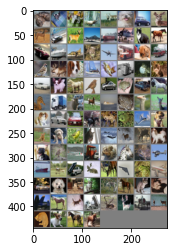

cat   dog   cat   deer  deer  dog   car   deer  horse car   deer  plane ship  plane cat   horse car   ship  plane frog  plane truck dog   truck bird  deer  dog   ship  cat   truck frog  cat   car   dog   horse bird  car   frog  car   horse bird  truck deer  horse ship  frog  bird  deer  dog   car   car   horse frog  frog  plane dog   cat   dog   bird  cat   plane deer  deer  dog   dog   bird  ship  truck frog  horse frog  plane ship  plane truck deer  deer  plane frog  plane car   dog   cat   cat   deer  horse cat   cat   plane horse cat   truck deer  deer  plane deer  cat   dog   horse horse


In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# functions to show an image

batch_size = 100
trainloader = train_data_loader
val_loader = valid_data_loader
testloader = eval_data_loader
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


**Creating Neural Network**

In [ ]:
net = Net()
net.to(device)

num_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("Number of trainable parameters:", num_params)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True, min_lr=0)

Number of trainable parameters: 18617482


**Starting Training**

In [ ]:
loss_hist, acc_hist = [], []
loss_hist_val, acc_hist_val = [], []

train_set = trainloader.dataset
val_set = val_loader.dataset

for epoch in range(20):
    running_loss = 0.0
    correct = 0
    for data in trainloader:
        batch, labels = data
        batch, labels = batch.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(batch)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # compute training statistics
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_set)
    avg_acc = correct / len(train_set)
    loss_hist.append(avg_loss)
    acc_hist.append(avg_acc)

    # validation statistics
    net.eval()
    with torch.no_grad():
        loss_val = 0.0
        correct_val = 0
        for data in val_loader:
            batch, labels = data
            batch, labels = batch.to(device), labels.to(device)

            outputs = net(batch)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            loss_val += loss.item()
        avg_loss_val = loss_val / len(val_set)
        avg_acc_val = correct_val / len(val_set)
        loss_hist_val.append(avg_loss_val)
        acc_hist_val.append(avg_acc_val)
    net.train()

    scheduler.step(avg_loss_val)
    print('[epoch %d] loss: %.5f accuracy: %.4f val loss: %.5f val accuracy: %.4f' % (epoch + 1, avg_loss, avg_acc, avg_loss_val, avg_acc_val))

print('Finished Training')

[epoch 1] loss: 0.01703 accuracy: 0.3860 val loss: 0.01324 val accuracy: 0.5066
[epoch 2] loss: 0.01297 accuracy: 0.5389 val loss: 0.01053 val accuracy: 0.6272
[epoch 3] loss: 0.01086 accuracy: 0.6188 val loss: 0.00864 val accuracy: 0.6996
[epoch 4] loss: 0.00923 accuracy: 0.6788 val loss: 0.00762 val accuracy: 0.7313
[epoch 5] loss: 0.00819 accuracy: 0.7162 val loss: 0.00693 val accuracy: 0.7504
[epoch 6] loss: 0.00723 accuracy: 0.7495 val loss: 0.00653 val accuracy: 0.7703
[epoch 7] loss: 0.00648 accuracy: 0.7764 val loss: 0.00637 val accuracy: 0.7743
[epoch 8] loss: 0.00588 accuracy: 0.7969 val loss: 0.00577 val accuracy: 0.7995
[epoch 9] loss: 0.00527 accuracy: 0.8176 val loss: 0.00580 val accuracy: 0.7997
[epoch 10] loss: 0.00471 accuracy: 0.8364 val loss: 0.00579 val accuracy: 0.8049
[epoch 11] loss: 0.00416 accuracy: 0.8553 val loss: 0.00587 val accuracy: 0.8087
[epoch 12] loss: 0.00378 accuracy: 0.8701 val loss: 0.00543 val accuracy: 0.8217
[epoch 13] loss: 0.00333 accuracy: 0.

**Saving model and reloading weights**

In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

dataiter = iter(testloader)
images, labels = dataiter.next()

net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

**Testing the model on test dataset**

In [ ]:
correct = 0
total = 0
pred_vec = []
net.eval()
test_set = testloader.dataset
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        pred_vec.append(predicted)
    pred_vec = torch.cat(pred_vec)            

print('Accuracy on the 10000 test images: %.2f %%' % (100 * correct / len(test_set)))

Accuracy on the 10000 test images: 83.29 %


### **6. Comparison and Summary**


Starting from logistic regression, we have 100 iterations being run to achieve an accuracy of approximately 42%. Then, svm w/o kernel is able to give an accuracy of approximately 35% over 1500 iterations and 54% with and RBF kernel. Later, we have designed a DNN without convolution layers which runs for 40 epochs to give an accuracy of approximately 55% but when added with convolution layers, it gives an accuracy of nearly 84% over 20 epochs. Thus DNN with CNN is the best model to classify Cifar-10 dataset.

It is evident from the graphs below that- 

for ***CNN*** as the epoch increases, the accuracy of the system keeps increasing and similarly the loss keeps decreasing. 



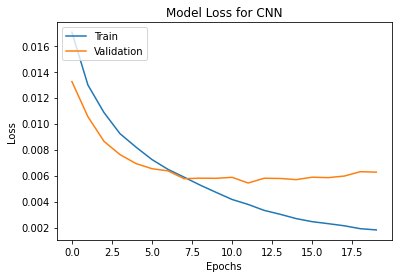

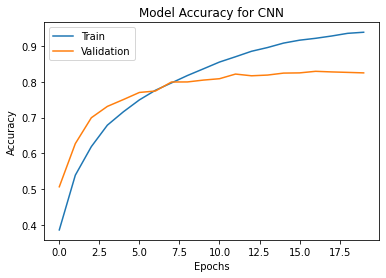

In [ ]:
legend = ['Train', 'Validation']
plt.plot(loss_hist)
plt.plot(loss_hist_val)
plt.title('Model Loss for CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(legend, loc='upper left')
plt.show()

legend = ['Train', 'Validation']
plt.plot(acc_hist)
plt.plot(acc_hist_val)
plt.title('Model Accuracy for CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(legend, loc='upper left')
plt.show()

for ***DNN without CNN*** as the epoch increases, the accuracy of the system keeps increasing and similarly the loss keeps decreasing. 


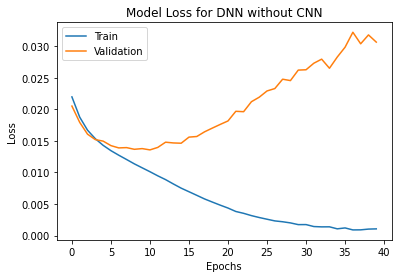

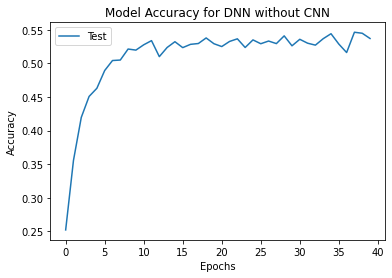

In [ ]:
legend = ['Train', 'Validation']
plt.plot(list(map(itemgetter("loss_value"), history_dnn)))
plt.plot(list(map(itemgetter("test_loss"), history_dnn)))
plt.title('Model Loss for DNN without CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(legend, loc='upper left')
plt.show()

legend = ['Test']
plt.plot(list(map(itemgetter("accuracy"), history_dnn)))
plt.title('Model Accuracy for DNN without CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(legend, loc='upper left')
plt.show()

for ***SVM without kernel*** the loss decreases over the epochs

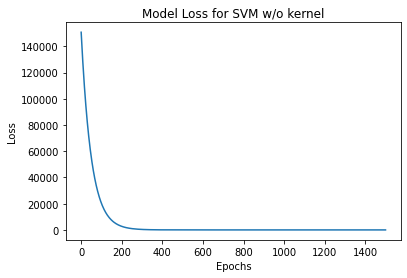

In [ ]:
plt.plot(loss_hist)
plt.title('Model Loss for SVM w/o kernel')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

for ***Logistic regression*** as the epoch increases, the accuracy of the system keeps increasing and similarly the loss keeps decreasing. 

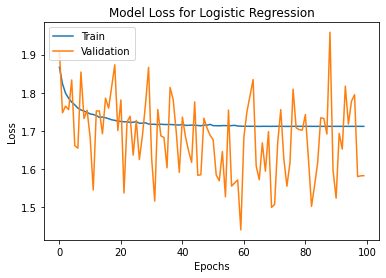

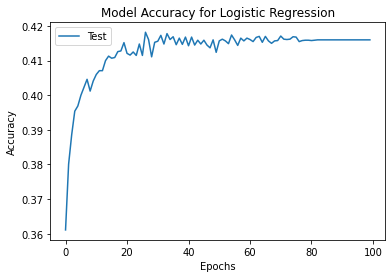

In [ ]:
# plotting loss graph
legend = ['Train', 'Validation']
plt.plot(list(map(itemgetter("val_loss"), history_log)))
plt.plot(list(map(itemgetter("train_loss"), history_log)))
plt.title('Model Loss for Logistic Regression')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(legend, loc='upper left')
plt.show()

# plotting accuracy graph
legend = ['Test']
plt.plot(list(map(itemgetter("val_metric"), history_log)))
plt.title('Model Accuracy for Logistic Regression')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(legend, loc='upper left')
plt.show()

### **Future scope**
The above models can be tuned by modifying their hyperparameters like learning rate, number of dense layers, type of optimizer, number of iterations/epochs and more. 